Bootstrap resampling to determine the confidence intervals of the population.

See the blog at: https://medium.com/p/cca9dc855d1b

In [64]:
# number stuff
import pandas as pd
import numpy as np

# plotting stuff
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import seaborn as sns

#from scipy import stats
# resampling
from sklearn.utils import resample


In [65]:
# Import the data into a Pandas Dataframe
df = pd.read_csv('data/event_2_donations.csv', index_col=0)

## look at  data

In [66]:
# total amount of donations
df.sum()

amount    2312.2
dtype: float64

In [67]:
# 5 point stats 
df.describe()

,amount
count,64.000000
mean,36.128125
std,46.502191
min,10.000000
25%,10.000000
50%,20.000000
75%,42.500000
max,303.000000


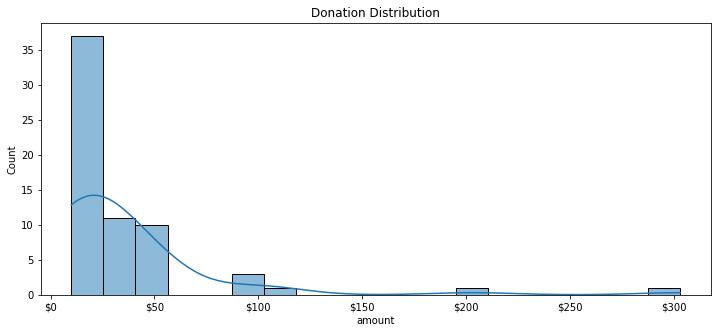

In [68]:
# plot the distribution of the donations

# set the size of the figure
plt.figure(figsize=(12,5))

# plot the histogram
ax = sns.histplot(df.amount, kde=True)

# set the title
plt.title('Donation Distribution')

# format the x axis as # amounts
formatter = ticker.FormatStrFormatter('$%1.0f')
ax.xaxis.set_major_formatter(formatter)

We can see from the 5 point stats that the minimum value for the Amount is 1. So the people who did not donate are not included.  We want to add them into this data as guests who donated zero. Our goal is to determine what the nonprofit can expect based on registrations.  If we don't include those our estimate will be too high.

The first event had 109 people register
The second event had 126 people register

To add those in we want to see the difference between the number of people who registered and the number of donations for that event, and pad the list with zeros for the people who didn't donate.

In [69]:
# count the number of people who did not donate by subtracting the total number
# of donations from the total number of registered attendees 
number_of_cheapskates = 126 - len(df)

# create a dataframe of 0's with length of equal to number_of_cheapskates
cheapskates = pd.DataFrame(np.zeros(number_of_cheapskates), 
                           columns = ['amount'])
cheapskates.head()

,amount
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [70]:
# check that we have the right number of cheapskates
len(cheapskates)

62

In [71]:
# create a new dataframe with all registered attendees and the amount they donated.
df_combined = pd.concat([df, cheapskates])

# get the new mean
sample_mean = df_combined['amount'].mean()
round(sample_mean, 2)

18.35

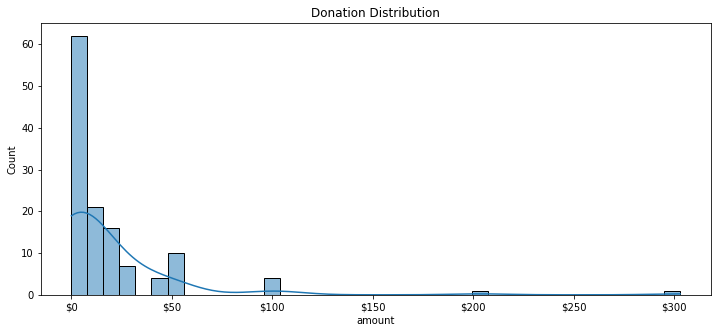

In [72]:
# plot the new distribution of the donations

# set the size of the figure
plt.figure(figsize=(12,5))

# plot the histogram
ax = sns.histplot(df_combined.amount, kde=True)

# set the title
plt.title('Donation Distribution')

# format the x axis as # amounts
formatter = ticker.FormatStrFormatter('$%1.0f')
ax.xaxis.set_major_formatter(formatter)

## Resample to find the population mean and confidence intervals.

Why?  Because we want to know what to expect for other similar events.  By resampling we get an estimator of the sampling variation in the population.  We look at the difference between the resampled mean and our sample mean to get a distribution of the errors which we can use to estimate the confidence intervals for samples of this size from the population.

For a large number of samples it will converge on an estimate of the distribution of the population.  Lets test how this converges

In [89]:
np.random.randint(10000)

3945

In [108]:
np.random.seed((3945))

# create an empy list to hold the resampled_means 
resample_means = []
for i in range(10000):
    resample_means.append(resample(df_combined.amount).mean())

In [204]:
# look at the first 5 resampled menas
resample_means[:5]

[17.049206349206347,
 17.61111111111111,
 23.106349206349204,
 20.207936507936505,
 18.84285714285714]

The mean of the resample_means will be about the same as the mean of our original sample.

In [205]:
print(f'Original Sample Mean: {round(sample_mean, 2)}')
print('Mean of resampled means:', round(np.mean(resample_means), 2))

Original Sample Mean: 18.35
Mean of resampled means: 18.34


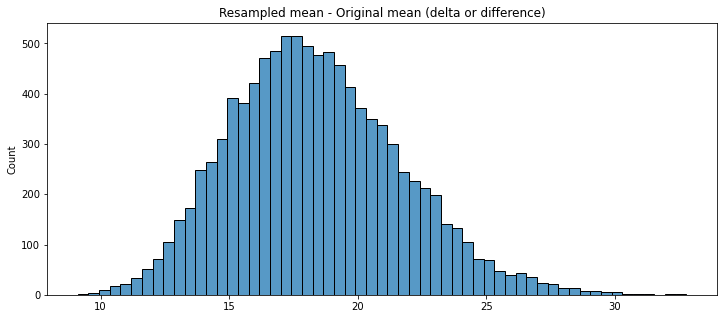

In [144]:
plt.figure(figsize=(12,5))
sns.histplot(resample_means)

plt.title('Resampled mean - Original mean (delta or difference)')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax.xaxis.set_major_formatter(formatter)


In [121]:
resample_means.sort()
np.round((resample_means[249], resample_means[9749]),2)

array([12.59, 25.46])

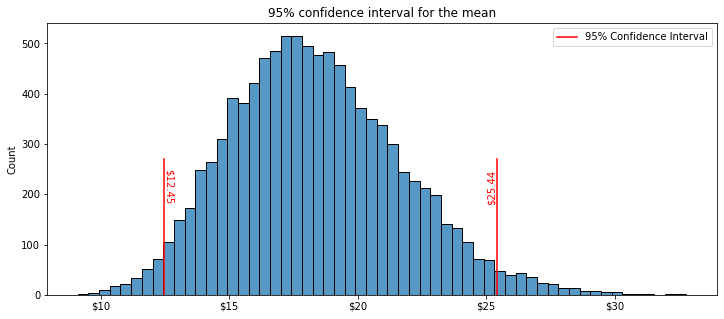

In [141]:
plt.figure(figsize=(12,5))
ax = sns.histplot(resample_means)

plt.title('95% confidence interval for the mean')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax.xaxis.set_major_formatter(formatter)

ax.axvline(12.45, 0, .5, color='r', label='95% Confidence Interval')
ax.axvline(25.44, 0, .5, color='r')

ax.text(12.45, 180, '$12.45', rotation=270, va='bottom', ha='left', color='r')
ax.text(25.4, 180, '$25.44', rotation=90, va='bottom', ha='right', color='r')


plt.legend()

In [142]:
resample_means.sort()
np.round(resample_means[99], 2)

11.68

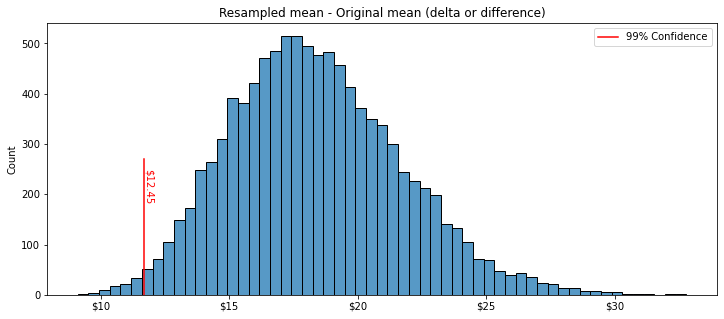

In [143]:
plt.figure(figsize=(12,5))
ax = sns.histplot(resample_means)

plt.title('Resampled mean - Original mean (delta or difference)')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax.xaxis.set_major_formatter(formatter)

ax.axvline(11.68, 0, .5, color='r', label='99% Confidence')
ax.text(11.68, 180, '$12.45', rotation=270, va='bottom', ha='left', color='r')

plt.legend()

Because we are using 1000 samples the quantile should be the same as record 250 and 975 from an ordered dataset.

# Plot convergance of confidence intervals

In [198]:
# create an empy list to hold the resampled_means 
resample_deltas = []
x = np.arange(10,40001,10)
for i in x:
    resample_deltas.append(resample(df_combined.amount).mean() - sample_mean)

In [199]:
y1 = []
y2 = []
for i in range(len(resample_deltas)):
    y1.append(np.quantile(resample_deltas[:i+1],.025))
    y2.append(np.quantile(resample_deltas[:i+1],.075))


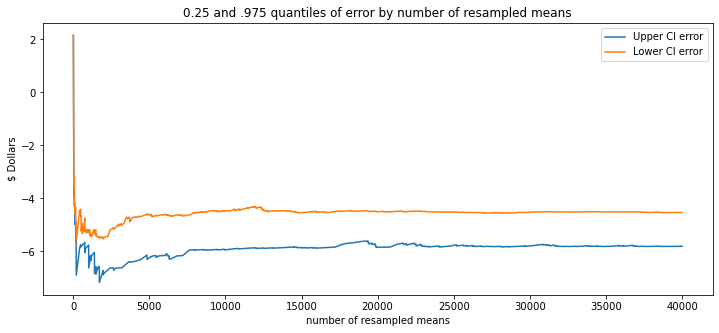

In [201]:
plt.figure(figsize=(12,5))
sns.lineplot(x=x, y=y1, label='Upper CI error')
sns.lineplot(x=x, y=y2, label='Lower CI error')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax.yaxis.set_major_formatter(formatter)

plt.title('0.25 and .975 quantiles of error by number of resampled means')
plt.xlabel('number of resampled means')
plt.ylabel('$ Dollars')

plt.legend()